In [16]:
using Gridap, Gridap.Geometry, Gridap.Fields, GridapGmsh
using LinearAlgebra
using NLopt
import Images: load, Gray
using CairoMakie, GridapMakie
using ChainRulesCore, Zygote
import ChainRulesCore: rrule
using FFTW
using Random
NO_FIELDS = ZeroTangent()

struct Control
    gridx::Array{Float64}
    gridy::Array{Float64}
    R::Float64
    β::Float64
    η::Float64
    R_smoothing::Float64
end

struct FEModel
    V::Gridap.FESpace
    U::Gridap.FESpace
    np::Int
    Ω::Gridap.Triangulation
    Ω_d::Gridap.Triangulation
    dΩ::Gridap.Measure
    dΩ_d::Gridap.Measure
    dΩ_c::Gridap.Measure
    dΓ_s::Gridap.Measure
end

struct Physics
    k::Float64
    n_metal::ComplexF64
    n_air::ComplexF64
    μ::ComplexF64
    R::Float64
    dpml::Float64
    LHp::Tuple{Float64, Float64}
    LHn::Tuple{Float64, Float64}
end

# PML coordinate streching functions
function s_PML(x; phys::Physics)
    σ = -3 / 4 * log(phys.R) / phys.dpml / phys.n_air
    xf = Tuple(x)
    u = @. ifelse(xf > 0 , xf - phys.LHp, - xf - phys.LHn)
    return @. ifelse(u > 0,  1 + (1im * σ / phys.k) * (u / phys.dpml)^2, $(1.0+0im))
end

function ds_PML(x; phys::Physics)
    σ = -3 / 4 * log(phys.R) / phys.dpml / phys.n_air
    xf = Tuple(x)
    u = @. ifelse(xf > 0 , xf - phys.LHp, - xf - phys.LHn)
    ds = @. ifelse(u > 0, (2im * σ / phys.k) * (1 / phys.dpml)^2 * u, $(0.0+0im))
    return ds.*sign.(xf)
end

struct Λ <: Function
    phys::Physics
end

function (Λf::Λ)(x)
    s_x,s_y = s_PML(x; Λf.phys)
    return VectorValue(1/s_x, 1/s_y)
end

# Define the derivative for the Λ factor
Fields.∇(Λf::Λ) = x -> TensorValue{2, 2, ComplexF64}(-(Λf(x)[1])^2 * ds_PML(x; Λf.phys)[1], 0, 0, -(Λf(x)[2])^2 * ds_PML(x; Λf.phys)[2])


ξd(p, n_air::ComplexF64, n_metal::ComplexF64)= 1 / (n_air + (n_metal - n_air) * p)^2 - 1 / n_air^2 # in the design region

a_base(u, v; phys::Physics) = (1 / phys.n_air^2) * ((∇ .* (Λ(phys) * v)) ⊙ (Λ(phys) .* ∇(u))) - (phys.k^2 * phys.μ * (v * u))

a_design(u, v, pth; phys::Physics) = ((p -> ξd(p, phys.n_air, phys.n_metal)) ∘ pth) * (∇(v) ⊙ ∇(u))

function MatrixA(pth; phys::Physics, fem::FEModel)
    A_mat = assemble_matrix(fem.U, fem.V) do u, v
        ∫(a_base(u, v; phys))fem.dΩ + ∫(a_design(u, v, pth; phys))fem.dΩ_d
    end
    return lu(A_mat)
end


function MatrixOf(fem::FEModel)
    x0 = VectorValue(0,300)  # Position of the field to be optimized
    δ = 1                    
    return assemble_matrix(fem.U, fem.V) do u, v
        ∫((x->(1/(2*π)*exp(-norm(x - x0)^2 / 2 / δ^2))) * (∇(u) ⋅ ∇(v)) )fem.dΩ_c
    end
end


"""
Filtering kernel
"""
function conic_filter(radius, Lx, Ly, resolution)

    xv = 0: 1/resolution: ceil(2 * radius / Lx) * Lx / 2
    yv = 0: 1/resolution: ceil(2 * radius / Ly) * Ly / 2

    X = repeat(xv, 1, length(yv))
    Y = repeat(yv', length(xv), 1)
    mask = X.^2 + Y.^2 .< radius.^2
    iftruemask = (1 .- sqrt.(abs.(X.^2 .+ Y.^2)) ./ radius)
    iffalsemask = zeros(size(X))
    h = ifelse.(mask,iftruemask,iffalsemask)

    # Filter the response
    return h
end

"""
FFT convolution scheme
"""
function properpad(arr, pad_to)

    pad_size = pad_to .- (2 .* size(arr)) .+ 1

    top = zeros(pad_size[1], size(arr,2))
    bottom = zeros(pad_size[1], size(arr,2) - 1)
    middle = zeros(pad_to[1], pad_size[2])

    top_left = arr[1:end, 1:end]
    top_right = reverse(arr[2:end, 1:end], dims=1)
    bottom_left = reverse(arr[1:end, 2:end], dims=2)
    bottom_right = reverse(
        reverse(arr[2:end, 2:end], dims=2), dims=1
    )  

    return hcat(
        vcat(top_left, top, top_right),
        middle,
        vcat(bottom_left, bottom, bottom_right),
    )
end

function edgepad(arr, pad)
    # fill sides
    left = repeat(arr[1, 1:end], outer=(1, pad[1][1]))'  # left side
    right = repeat(arr[end, 1:end], outer=(1, pad[1][2]))'  # right side
    top = repeat(arr[1:end, 1], outer=(1, pad[2][1]))  # top side
    bottom = repeat(arr[1:end, end], outer=(1, pad[2][2]))  # bottom side)

    # fill corners
    top_left = repeat([arr[1, 1]], outer=(pad[2][1], pad[1][1]))'  # top left
    top_right = repeat([arr[end, 1]], outer=(pad[2][1], pad[1][2]))'  # top right
    bottom_left = repeat([arr[1, end]], outer=(pad[2][2], pad[1][1]))'  # bottom left
    bottom_right = repeat([arr[end, end]], outer=(pad[2][2], pad[1][2]))'  # bottom right

    if (pad[1][1] > 0) & (pad[1][2] > 0) & (pad[2][1] > 0) & (pad[2][2] > 0)
        return hcat(
            vcat(top_left, top, top_right),
            vcat(left, arr, right),
            vcat(bottom_left, bottom, bottom_right),
        )
    elseif (pad[1][1] == 0) & (pad[1][2] == 0) & (pad[2][1] > 0) & (pad[2][2] > 0)
        return hcat((top, arr, bottom))
    elseif (pad[1][1] > 0) & (pad[1][2] > 0) & (pad[2][1] == 0) & (pad[2][2] == 0)
        return hcat((left, arr, right))
    elseif (pad[1][1] == 0) & (pad[1][2] == 0) & (pad[2][1] == 0) & (pad[2][2] == 0)
        return arr
    else
        throw(ErrorException("Not Implemented"))
    end
end

function centeredfft(arr, newshape)
    currshape = size(arr)
    startind = floor.((currshape .- newshape) ./ 2)
    endind = startind .+ newshape
    myslice = [Int(st)+1:Int(en) for (st, en) ∈ zip(startind, endind)]
    return arr[myslice...]
end

function convolvefft(x; h)
    # Reshape image and kernel for fft convolution
    sx, sy = size(x)

    (kx, ky) = size(h)

    npx = Integer(
        ceil((2 * kx - 1) / sx)
    )  # 2*kx-1 is the size of a complete kernel in the x direction
    npy = Integer(
        ceil((2 * ky - 1) / sy)
    )  # 2*ky-1 is the size of a complete kernel in the y direction
    if npx % 2 == 0
        npx += 1  # Ensure npx is an odd number
    end
    if npy % 2 == 0
        npy += 1  # Ensure npy is an odd number
    end
    x = repeat(
        x, outer=(npx, npy)
    )
    x = edgepad(
        x, ((0, 0), (0, 0))
    )  
    h = properpad(
        h, (npx * sx, npy * sy),
    )

    h = h ./ sum(h)
    xout = centeredfft(
        real(ifft(fft(x) .* fft(h))), [sx, sy]
    )
end

"""
Filter the grid
"""
function filter_grid(p_vec::Array{Float64}; control::Control)
    # Get filter
    Lx = control.gridx[end] - control.gridx[1]
    Ly = control.gridy[end] - control.gridy[1]
    resolution = (length(control.gridx) - 1) / Lx
    h = conic_filter(control.R, Lx, Ly, resolution)
    
    # Reshape image and kernel for fft convolution
    design_grid = deflatten(p_vec; gridx=control.gridx, gridy=control.gridy)
    xout = convolvefft(design_grid; h)
    pf_vec = flatten(xout)
    return pf_vec
end

function tanh_projection(x; control::Control)
    β = control.β
    η = control.η
    
    if β == Inf
        return ifelse.(x .> η, 1.0, 0.0) 
    end
    
    return ((tanh(β * η) .+ tanh.(β .* (x .- η))) ./
            (tanh(β * η) .+ tanh(β * (1.0 .- η))))
end

function compute_gradient(input_array::AbstractArray{Float64})
    # Compute gradients
    gradient_x = (input_array[3:end, :] .- input_array[1:end-2, :]) ./ 2.0
    gradient_x_left = reshape(input_array[2, :] .- input_array[1, :], 1, size(input_array, 2))
    gradient_x_right = reshape(input_array[end, :] .- input_array[end-1, :], 1, size(input_array, 2))
    gradient_x = vcat(gradient_x_left, gradient_x, gradient_x_right)

    gradient_y = (input_array[:, 3:end] .- input_array[:, 1:end-2]) ./ 2.0
    gradient_y_top = reshape(input_array[:, 2] .- input_array[:, 1], size(input_array, 1), 1)
    gradient_y_bottom = reshape(input_array[:, end] .- input_array[:, end-1], size(input_array, 1), 1)
    gradient_y = hcat(gradient_y_top, gradient_y, gradient_y_bottom)
    
    # Return gradients as a tuple
    return gradient_x, gradient_y
end

function smoothed_projection(
    pf_vec::Array{Float64}; control::Control
)
    β = control.β
    η = control.η
    Lx = control.gridx[end] - control.gridx[1]
    Ly = control.gridy[end] - control.gridy[1]
    resolution = (length(control.gridx) - 1) / Lx
    x_smoothed = deflatten(pf_vec; gridx=control.gridx, gridy=control.gridy)

    dx = dy = 1 / resolution
    # dx = dy = 2 * control.R_smoothing
    # pixel_radius = dx / 2
    pixel_radius = control.R_smoothing
    x_projected = tanh_projection(x_smoothed; control)
    x_grad_x, x_grad_y = compute_gradient(x_smoothed)
    x_grad_helper = (x_grad_x / dx) .^ 2 + (x_grad_y / dy) .^ 2
    nonzero_norm = abs.(x_grad_helper) .> 0
    x_grad_norm = sqrt.(ifelse.(nonzero_norm, x_grad_helper, 1))
    x_grad_norm_eff = ifelse.(nonzero_norm, x_grad_norm, 1)
    d = (η .- x_smoothed) ./ x_grad_norm_eff
    needs_smoothing = nonzero_norm .& (abs.(d) .<= pixel_radius)

    R = d ./ pixel_radius
    fill_factor = ifelse.(
        needs_smoothing,
        0.5 .- 15/16 * R .+ 5/8 * R .^ 3 .- 3 / 16 * R .^ 5,
        1,
    )
    x_minus = x_smoothed .- x_grad_norm * pixel_radius
    x_plus = x_smoothed .+ x_grad_norm * pixel_radius
    x_minus_eff_pert = (x_smoothed .* d .+ x_minus .* (pixel_radius .- d)) / pixel_radius
    x_minus_eff = ifelse.(
        (d .> 0),
        x_minus_eff_pert,
        x_minus,
    )
    x_plus_eff_pert = (-x_smoothed .* d + x_plus .* (pixel_radius .+ d)) / pixel_radius
    x_plus_eff = ifelse.(
        (d .> 0),
        x_plus,
        x_plus_eff_pert,
    )

    x_plus_eff_projected = tanh_projection(x_plus_eff; control)
    x_minus_eff_projected = tanh_projection(x_minus_eff; control)

    x_projected_smoothed = (1 .- fill_factor) .* x_minus_eff_projected .+ (fill_factor) .* x_plus_eff_projected
    return flatten(ifelse.(
        needs_smoothing,
        x_projected_smoothed,
        x_projected,
    ))
end


"""
Takes a rectilinear design grid and projects it onto an FE grid using a bilinear interpolation
"""
function rect2fe(r; design_grid, gridx, gridy)
    (x, y) = r
    pf = 0.0

    # Find x vals
    rx = searchsortedfirst(gridx, x)
    lx = rx - 1
    Δx_r = gridx[rx] - x

    # Find y vals
    ry = searchsortedfirst(gridy, y)
    ly = ry - 1
    Δy_r = gridy[ry] - y
    if (ly == 0) & (lx == 0)
        Δx_l = 0.0
        Δy_l = 0.0
        return design_grid[rx, ry]
    elseif ly == 0
        Δx_l = x - gridx[lx]
        Δy_l = 0.0
        return (
            design_grid[lx, ry] * Δx_r + design_grid[rx, ry] * Δx_l
        ) / (Δx_r + Δx_l)
    elseif lx == 0
        Δx_l = 0.0
        Δy_l = y - gridy[ly]
        return (
            design_grid[rx, ly] * Δy_r + design_grid[rx, ry] * Δy_l
        ) / (Δy_r + Δy_l)
    else
        Δx_l = x - gridx[lx]
        Δy_l = y - gridy[ly]
    end

    pf = (
        design_grid[lx, ly] * Δx_r * Δy_r + 
        design_grid[rx, ly] * Δx_l * Δy_r + 
        design_grid[lx, ry] * Δx_r * Δy_l + 
        design_grid[rx, ry] * Δx_l * Δy_l
    ) / ((Δy_r + Δy_l) * (Δx_r + Δx_l))
end

function get_ptfe(pt_vec::Array{Float64}; control::Control)
    design_grid = deflatten(pt_vec; gridx=control.gridx, gridy=control.gridy)
    ptfe = (r -> rect2fe(r; design_grid, gridx=control.gridx, gridy=control.gridy))
end


"""
Some lightweight vector manipulation functions
"""
flatten(design_grid) = reshape(design_grid, length(design_grid))
deflatten(pvec; gridx, gridy) = reshape(pvec,(length(gridx), length(gridy)))
Base.log(a::CellField) = Operation(Base.log)(a)
Base.real(uh::VectorValue) = VectorValue(real.(Tuple(uh)))
Base.imag(uh::VectorValue) = VectorValue(imag.(Tuple(uh)))
Base.abs(uh::VectorValue) = VectorValue(abs.(Tuple(uh)))


function get_cell_weights(dΩ::Gridap.CellData.Measure)
    get_cell_weights(dΩ.quad)
end

function get_cell_weights(quad::Gridap.CellData.CellQuadrature)
  if quad.data_domain_style == PhysicalDomain() && quad.integration_domain_style == PhysicalDomain()
    quad.cell_weight
  elseif quad.data_domain_style == ReferenceDomain() && quad.integration_domain_style == PhysicalDomain()
    cell_map = get_cell_map(quad.trian)
    cell_Jt = lazy_map(∇,cell_map)
    cell_Jtx = lazy_map(evaluate,cell_Jt,quad.cell_point)
    cell_m = lazy_map(Broadcasting(Gridap.TensorValues.meas),cell_Jtx)
    lazy_map(Broadcasting(*),quad.cell_weight,cell_m)
  elseif quad.data_domain_style == ReferenceDomain() && quad.integration_domain_style == ReferenceDomain()
    quad.cell_weight
  else
    Gridap.Helpers.@notimplemented
  end
end

function quadratureloop(func, a; fem::FEModel)

    # Unpack fem
    U = fem.U
    V = fem.V
    Ω = fem.Ω_d
    dΩ = fem.dΩ_d

    dv = get_fe_basis(V)
    du = get_trial_fe_basis(U)

    p = get_cell_points(dΩ)
    cell_ax = a(du,dv)(p)
    cell_w = get_cell_weights(dΩ)
    cell_x = Gridap.CellData.get_array(p)
    cell_dof_ids = get_cell_dof_ids(U,Ω)

    c1 = array_cache(cell_ax)
    c2 = array_cache(cell_w)
    c3 = array_cache(cell_x)
    c4 = array_cache(cell_dof_ids)
    ncells = length(cell_ax)

    for cell in 1:ncells
        ax = getindex!(c1,cell_ax,cell)
        ws = getindex!(c2,cell_w,cell)
        xs = getindex!(c3,cell_x,cell)
        indices = getindex!(c4,cell_dof_ids,cell)
        for q ∈ 1:length(cell_w[1])
            aₓ = ax[q,:,:]
            x = xs[q]
            wₓ = ws[q]
            func(aₓ, x, wₓ, indices)
        end
    end
end

function updatejacobian!(i, vertex, weight; tempjacobian, gridx, gridy)
    (x, y) = vertex

    # Find x vals
    rx = searchsortedfirst(gridx, x)
    lx = rx - 1
    Δx_r = gridx[rx] - x

    # Find y vals
    ry = searchsortedfirst(gridy, y)
    ly = ry - 1
    Δy_r = gridy[ry] - y

    # Update jacobian
    if (ly == 0) & (lx == 0)
        Δx_l = 0.0
        Δy_l = 0.0
        tempjacobian[rx, ry, i] += weight
        return
    elseif ly == 0
        Δx_l = x - gridx[lx]
        Δy_l = 0.0
        den = (Δx_r + Δx_l)
        tempjacobian[lx, ry, i] += weight * Δx_r / den
        tempjacobian[rx, ry, i] += weight * Δx_l / den
        return
    elseif lx == 0
        Δx_l = 0.0
        Δy_l = y - gridy[ly]
        den = (Δy_r + Δy_l)
        tempjacobian[rx, ly, i] += weight * Δy_r / den
        tempjacobian[rx, ry, i] += weight * Δy_l / den
        return
    else
        Δx_l = x - gridx[lx]
        Δy_l = y - gridy[ly]
        den = (Δy_r + Δy_l) * (Δx_r + Δx_l)
        tempjacobian[lx, ly, i] += weight * Δx_r * Δy_r / den
        tempjacobian[rx, ly, i] += weight * Δx_l * Δy_r / den
        tempjacobian[lx, ry, i] += weight * Δx_r * Δy_l / den
        tempjacobian[rx, ry, i] += weight * Δx_l * Δy_l / den
        return
    end
end

Dξdpt(pt, n_air, n_metal, β, η)= 2 * (n_air - n_metal) / (n_air + (n_metal - n_air) * pt)^3

DAdpt(u, v, pfh; phys::Physics, control::Control) = ((p -> Dξdpt(p, phys.n_air, phys.n_metal, control.β, control.η)) ∘ pfh) * (∇(v) ⊙ ∇(u))

function gf_pt(pt_vec::Array{Float64}; control::Control, phys::Physics, fem::FEModel)
    ptfe = get_ptfe(pt_vec; control)
    A_mat = MatrixA(ptfe; phys, fem)
    b_vec = assemble_vector(v->(∫(v)fem.dΓ_s), fem.V)
    u_vec = A_mat \ b_vec
    
    O_mat = MatrixOf(fem)
    real(u_vec' * O_mat * u_vec)
end

function rrule(::typeof(gf_pt), pt_vec::Array{Float64}; control::Control, phys::Physics, fem::FEModel)
    function U_pullback(dgdg)
      NO_FIELDS, dgdg * Dgfdpt(pt_vec; control, phys, fem)
    end
    gf_pt(pt_vec; control, phys, fem), U_pullback
end

function Dgfdpt(pt_vec::Array{Float64}; control::Control, phys::Physics, fem::FEModel)
    gridx, gridy = control.gridx, control.gridy
    design_grid = deflatten(pt_vec; gridx, gridy)
    pth = get_ptfe(pt_vec; control)

    A_mat = MatrixA(pth; phys, fem)
    b_vec = assemble_vector(v->(∫(v)fem.dΓ_s), fem.V)
    u_vec = A_mat \ b_vec
    O_mat = MatrixOf(fem)
    
    uh = FEFunction(fem.U, u_vec)
    w_vec =  A_mat' \ (O_mat * u_vec)
    wconjh = FEFunction(fem.U, conj(w_vec)) 
    
    a_dg_dpt = (u,v) -> (
        real(-2 * DAdpt(uh, wconjh, pth; phys, control))
    )

    grad = zeros(size(design_grid,1), size(design_grid,2), 1)
    quadratureloop(a_dg_dpt; fem=fem) do aₓ, x, wₓ, indices
        val = sum(wₓ * aₓ)
        updatejacobian!(1, x, val; tempjacobian=grad, gridx, gridy)
    end
    grad_g = flatten(grad[:,:,1])
    return grad_g
end

function gf_p(p0::Vector; control::Control, phys::Physics, fem::FEModel)
    # Filter the grid
    pf_vec = filter_grid(p0; control)

    # Threshold projection
    pt_vec = smoothed_projection(pf_vec; control)

    gf_pt(pt_vec; control, phys, fem)
end

function gf_p!(p0::Vector, grad::Vector; control::Control, phys::Physics, fem::FEModel, g_ar::Array{Float64})
    if length(grad) > 0
        dgdp, = Zygote.gradient(p -> gf_p(p; control, phys, fem), p0)
        grad[:] = dgdp
    end
    gvalue = gf_p(p0::Vector; control, phys, fem)
    push!(g_ar, gvalue)
    @show gvalue
    flush(stdout)
    Libc.flush_cstdio()
    gvalue
end

function gf_p_optimize!(p_init::Array{Float64}; TOL::Float64 = 1e-4, MAX_ITER::Int = 500, control::Control, phys::Physics, fem::FEModel, g_ar::Array{Float64})
    ##################### Optimize #################
    opt = Opt(:LD_MMA, fem.np)
    opt.lower_bounds = 0
    opt.upper_bounds = 1
    opt.ftol_rel = TOL
    opt.maxeval = MAX_ITER
    opt.max_objective = (p0, grad) -> gf_p!(p0, grad; control, phys, fem, g_ar)

    (g_opt, p_opt, ret) = optimize(opt, p_init)
    @show numevals = opt.numevals # the number of function evaluations
    return g_opt, p_opt
end

function test_gradients(design_grid::Array{Float64}; control::Control, phys::Physics, fem::FEModel)
    p0 = rand(Float64, length(design_grid))
    δp = rand(Float64, length(design_grid))*1e-8
    grad = zeros(length(design_grid))
    g0 = gf_p!(p0, grad; control, phys, fem, g_ar=Float64[])
    g1 = gf_p!(p0+δp, []; control, phys, fem, g_ar=Float64[])
    fdv = g1-g0
    adjv = grad'*δp
    @show abs((fdv - adjv)/fdv)
end

function test_projection(design_grid::Array{Float64}; control::Control, fem::FEModel)
    grid = zeros(size(design_grid))
    grid .= design_grid
    p_test = flatten(grid)
    pf_vec = filter_grid(p_test; control)
    pt_vec = smoothed_projection(pf_vec; control)
    grid .= deflatten(pt_vec; gridx=control.gridx, gridy=control.gridy)
    ptfe = get_ptfe(pt_vec; control)

    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel="x", ylabel="y", aspect=1.0, title="FEM Grid")
    base_colormap = Makie.colorschemes[:Greys]
    transparent_colormap = [(color, alpha) for (color, alpha) in zip(base_colormap, LinRange(0, 1, length(base_colormap)))]
    plt = plot!(ax, fem.Ω_d, ptfe, colormap=transparent_colormap, colorrange=(0, 1))

    img = Gray.(1 .- grid')
    ax = Axis(fig[1, 2]; xlabel="x", ylabel="y", aspect=1.0, title="Bilinear Grid")
    plt = image!(ax, rotr90(reverse(img, dims=1)), colorrange=(0, 1))

    fig
end

function topopt(design_grid::Array{Float64}; control::Control, phys::Physics, fem::FEModel, MAX_ITER = 100, β_list = [8.0, Inf], TOL = 1e-8)
    gridx = control.gridx
    gridy = control.gridy
    R = control.R
    β = control.β
    η = control.η
    p_opt = flatten(design_grid) # Initial guess

    g_opt = 0
    g_ar = Float64[]
    for β in β_list
        control = Control(gridx, gridy, R, β, η, control.R_smoothing)
        g_opt, p_temp_opt = gf_p_optimize!(p_opt; TOL, MAX_ITER, control, phys, fem, g_ar)
        p_opt .= p_temp_opt
    end

    pf_vec = filter_grid(p_opt; control)
    pt_vec = smoothed_projection(pf_vec; control)
    pth = get_ptfe(pt_vec; control)

    A_mat = MatrixA(pth; phys, fem)
    b_vec = assemble_vector(v->(∫(v)fem.dΓ_s), fem.V)
    u_vec = A_mat \ b_vec
    uh = FEFunction(fem.U, u_vec)
    
    return g_ar, g_opt, p_opt, pth, uh
end

sumabs2(uh::VectorValue) = sum(abs.(Tuple(uh)).^2)

function postprocess(design_grid::Array{Float64}, g_ar::Array{Float64}, pth, uh; control::Control, phys::Physics, fem::FEModel)
    fig = Figure(resolution=(1200, 1200))
    g11 = fig[1, 1] = GridLayout()
    g12 = fig[1, 2] = GridLayout()
    g21 = fig[2, 1] = GridLayout()
    R_m = 100    # Radius of the circular design region
    R_l = 10    # Radius of the circular enhanced region
    L = 600      # Width of the numerical cell (excluding PML) (nm)
    
    ax = g12[1,2] = Axis(
        g12[1,2], aspect=1.0,
        xlabel="x (nm)", ylabel="y (nm)", title="Raman Emission", 
    )
    plt = plot!(ax, fem.Ω, sqrt∘sumabs2∘∇(uh), colorrange=(0, 30))
    Colorbar(g12[1,1], plt, label="|E|", vertical=true, halign=:right)
    base_colormap = Makie.colorschemes[:Greys]
    transparent_colormap = [(color, alpha) for (color, alpha) in zip(base_colormap, LinRange(0, 1, length(base_colormap)))]
    plt2 = plot!(ax, fem.Ω_d, pth, colormap=transparent_colormap, colorrange=(0, 1))
    xlims!(ax, -R_m*1.001, R_m*1.001)
    ylims!(ax, L/2-R_m*1.001, L/2+R_m*1.001)
    
    ax = g11[1,1] = Axis(
        g11[1,1], 
        xlabel="iteration", ylabel="g", title="iteration history"
    )
    lines!(ax, g_ar, color=:blue, linewidth=2)

    ax = Axis(g21[1, 1]; xlabel="x", ylabel="y", aspect=1.0, title="FEM Grid")
    base_colormap = Makie.colorschemes[:Greys]
    transparent_colormap = [(color, alpha) for (color, alpha) in zip(base_colormap, LinRange(0, 1, length(base_colormap)))]
    plt = plot!(ax, fem.Ω_d, pth, colormap=transparent_colormap, colorrange=(0, 1))

    img = Gray.(1 .- design_grid')
    ax = Axis(g21[1, 2]; xlabel="x", ylabel="y", aspect=1.0, title="Bilinear Grid")
    plt = image!(ax, rotr90(reverse(img, dims=1)), colorrange=(0, 1))

    return fig
end

function setup()

    # Build the physics model
    λ = 532      # Wavelength (nm)
    R_m = 100    # Radius of the circular design region
    L = 600      # Width of the numerical cell (excluding PML) (nm)
    h1 = 600     # Height of the air region below the source (nm)
    h2 = 200     # Height of the air region above the source (nm)
    dpml = 300   # Thickness of the PML (nm)

    n_metal = 0.054 + 3.429im # Silver refractive index at λ = 532 nm
    n_air = 1    # Air refractive index
    μ = 1        # Magnetic permeability
    k = 2*π/λ    # Wavenumber (nm^-1)

    R_pml = 1e-10
    LHp=(L/2, h1+h2)   # Start of PML for x,y > 0
    LHn=(L/2, 0)       # Start of PML for x,y < 0
    phys = Physics(k, n_metal, n_air, μ, R_pml, dpml, LHp, LHn)

    # Build the FEM Model
    model = GmshDiscreteModel("RecCirGeometry.msh")

    order = 1
    reffe = ReferenceFE(lagrangian, Float64, order)
    V = TestFESpace(model, reffe, dirichlet_tags = ["DirichletEdges", "DirichletNodes"], vector_type = Vector{ComplexF64})
    U = V   # mathematically equivalent to TrialFESpace(V,0)

    Ω = Triangulation(model)
    dΩ = Measure(Ω, 4)

    Γ_s = BoundaryTriangulation(model; tags = ["Source"]) # Source line 
    dΓ_s = Measure(Γ_s, 4)

    q = 10
    Ω_d = Triangulation(model, tags="Design")
    dΩ_d = Measure(Ω_d, q)

    Ω_c = Triangulation(model, tags="Center")
    dΩ_c = Measure(Ω_c, 4)

    nx, ny = (532, 532)
    np = nx * ny
    R_smoothing = 2 / q^2
    fem = FEModel(V, U, np, Ω, Ω_d, dΩ, dΩ_d, dΩ_c, dΓ_s)

    # Build the control model
    gridx = Array{Float64}(range(-R_m*1.001, R_m*1.001, length=nx))
    gridy = Array{Float64}(range(L/2-R_m*1.001, L/2+R_m*1.001, length=ny))
    design_grid = 0.5 .* ones(Float64, (nx, ny))

    # Control parameters
    β = 8.0
    η = 0.5
    R = 10.0
    control =  Control(gridx, gridy, R, β, η, R_smoothing)

    return control, phys, fem, design_grid
end

setup (generic function with 1 method)

Info    : Reading 'RecCirGeometry.msh'...
Info    : 26 entities
Info    : 55606 nodes
Info    : 111832 elements
Info    : Done reading 'RecCirGeometry.msh'                                


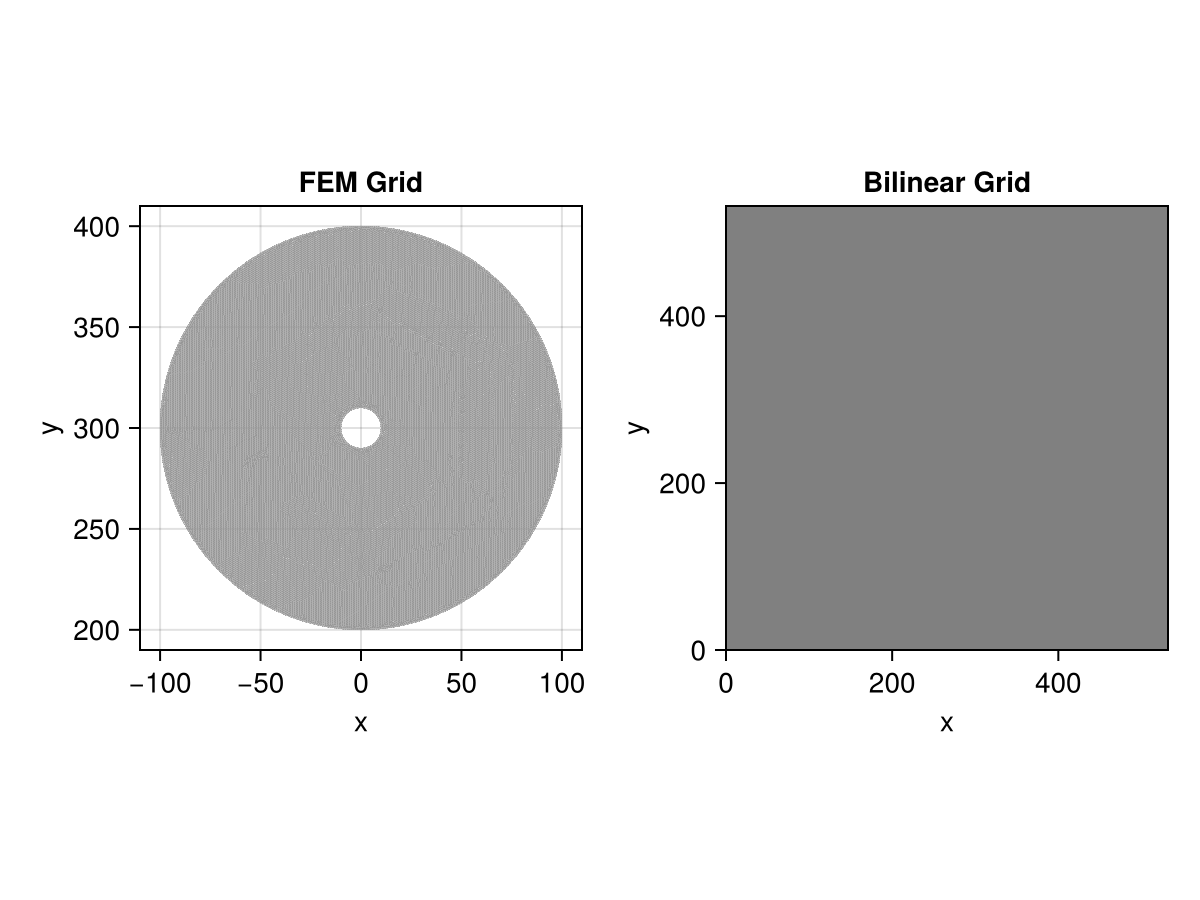

In [17]:
Random.seed!(1234)
path = @__DIR__

# Setup the simulation
control, phys, fem, design_grid = setup()
flush(stdout)
Libc.flush_cstdio()

# Test projection
fig = test_projection(design_grid; control, fem)

gvalue = 0.10346577149428524
gvalue = 0.10361429862994956
gvalue = 0.10510878571571766
gvalue = 0.12838857425467987
gvalue = 0.5998148215916743
gvalue = 6.357206700546763
gvalue = 11.532793248671442
gvalue = 16.68019023522009
gvalue = 26.059758211868207
gvalue = 29.975595466563874
gvalue = 20.684807870179583
gvalue = 29.646560747567534
gvalue = 32.244136357142935
gvalue = 33.52560151161155
gvalue = 34.849292473420434
gvalue = 35.76064785042057
gvalue = 34.942755209553205
gvalue = 37.50092562458997
gvalue = 38.41624403274519
gvalue = 39.04562251802105
gvalue = 38.57423226580556
gvalue = 39.55640486239072
gvalue = 39.916870424820786
gvalue = 40.734907267814016
gvalue = 41.48368463787243
gvalue = 39.209894260479345
gvalue = 42.045321084260294
gvalue = 42.43771708823848
gvalue = 42.92363906761018
gvalue = 42.89543932139611
gvalue = 43.005604682661655
gvalue = 43.248575299114385
gvalue = 43.547187504934385
gvalue = 44.2021643768442
gvalue = 43.958449078411064
gvalue = 43.98124787874915
gval

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/ianhammond/.julia/packages/Makie/iRM0c/src/scenes.jl:220


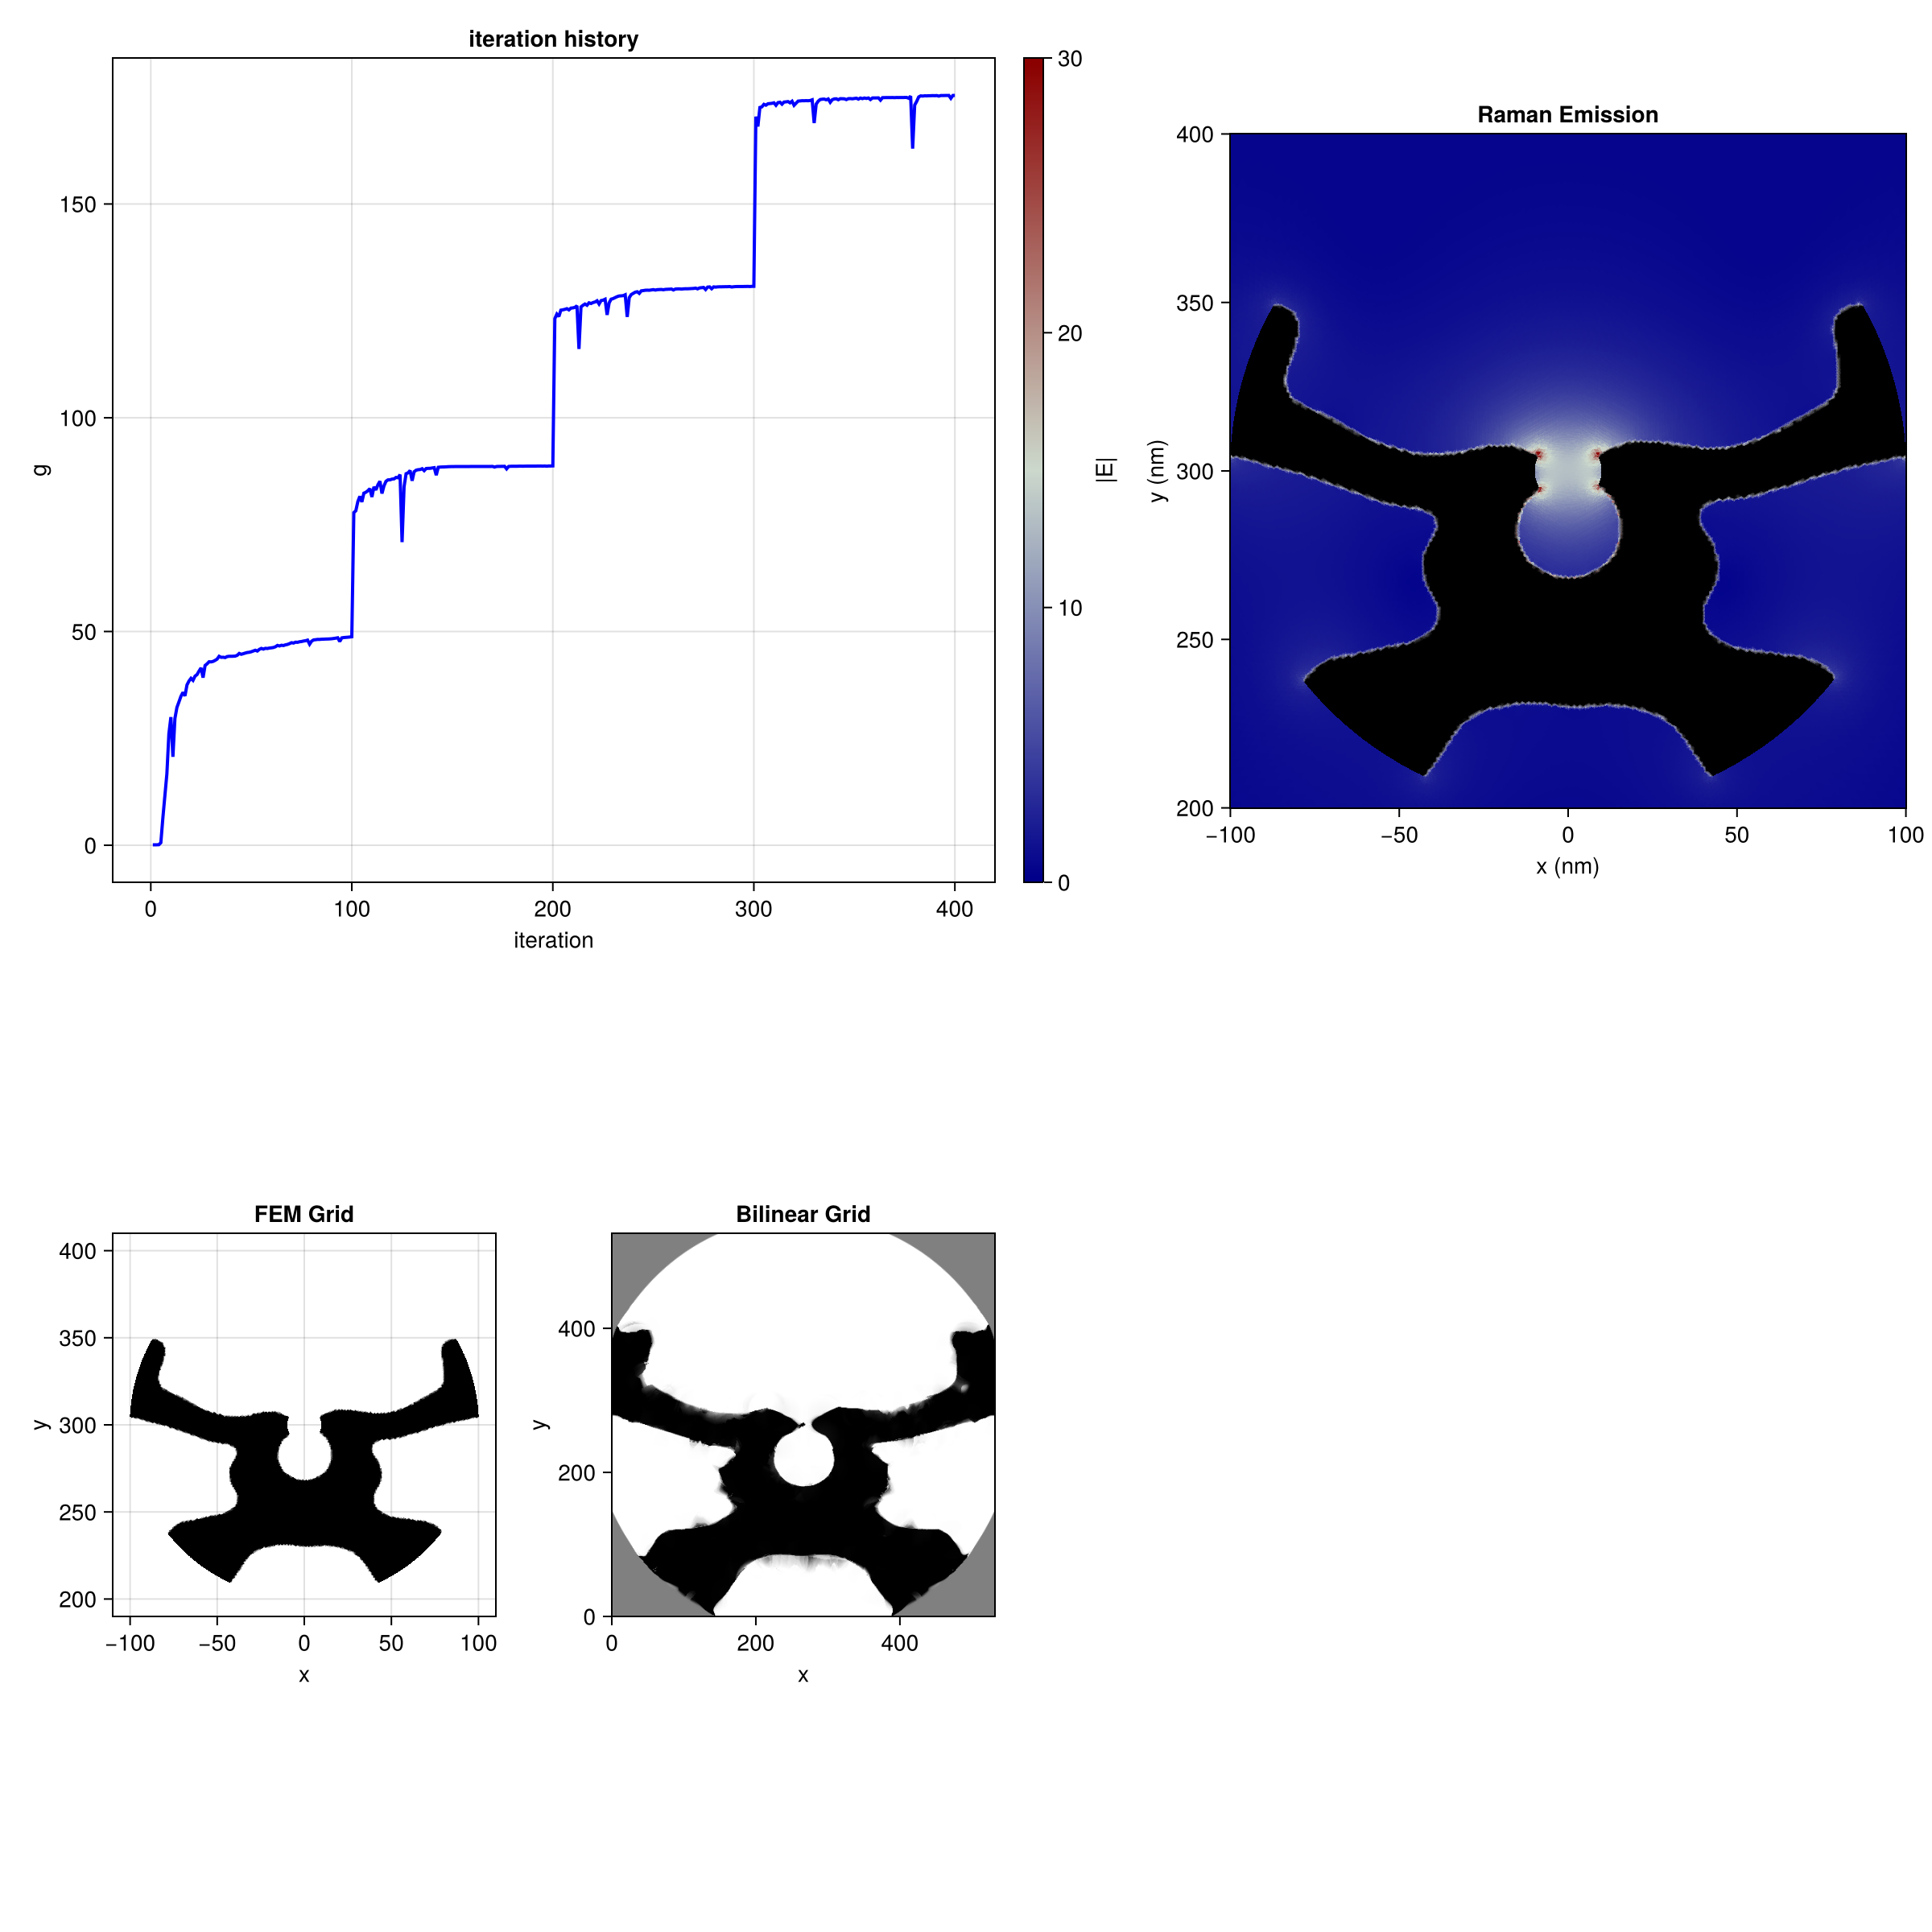

In [18]:
# Run optimization
g_ar, g_opt, p_opt, pth, uh = topopt(design_grid; control, phys, fem, MAX_ITER = 100, β_list = [8.0, 16.0, 32.0, Inf])
@show g_opt
design_grid .= reshape(p_opt, size(design_grid))

# Postprocess
fig = postprocess(design_grid, g_ar, pth, uh; control, phys, fem) 